In [3]:
import datetime as dt
import itertools
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from remake import load_remake

from mcs_prime import PATHS, McsTracks, PixelData
from mcs_prime.util import update_progress
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [4]:
mle = load_remake('../../remakefiles/mcs_local_envs.py')


TODOS
* Make sure filenames are consistent
* Make sure variables names are sensible/consistent
* Docstrings for all fns, classes
* Validate all data
* Consistent attrs for all created .nc files
* Units on data vars etc.



In [5]:
t = mle.McsLocalEnv.tasks.filter(mode='init')[0]

In [6]:
ds = xr.open_dataset(t.outputs['mcs_local_env'])

In [7]:
ds

<xarray.Dataset>
Dimensions:                                            (time: 1, latitude: 481,
                                                        longitude: 1440,
                                                        radius: 5)
Coordinates:
  * time                                               (time) datetime64[ns] ...
  * radius                                             (radius) int64 1 ... 1000
  * latitude                                           (latitude) float32 60....
  * longitude                                          (longitude) float32 0....
Data variables: (12/13)
    cape                                               (time, latitude, longitude) float64 ...
    mcs_local_cape                                     (time, radius, latitude, longitude) float64 ...
    tcwv                                               (time, latitude, longitude) float64 ...
    mcs_local_tcwv                                     (time, radius, latitude, longitude) float64 ...
    shear_0                                            (time, latitude, longitude) float64 ...
    mcs_local_shear_0                                  (time, radius, latitude, longitude) float64 ...
    ...                                                 ...
    mcs_local_shear_1                                  (time, radius, latitude, longitude) float64 ...
    shear_2                                            (time, latitude, longitude) float64 ...
    mcs_local_shear_2                                  (time, radius, latitude, longitude) float64 ...
    vertically_integrated_moisture_flux_div            (time, latitude, longitude) float64 ...
    mcs_local_vertically_integrated_moisture_flux_div  (time, radius, latitude, longitude) float64 ...
    dist_mask_sum                                      (time, radius, latitude, longitude) float64 ...

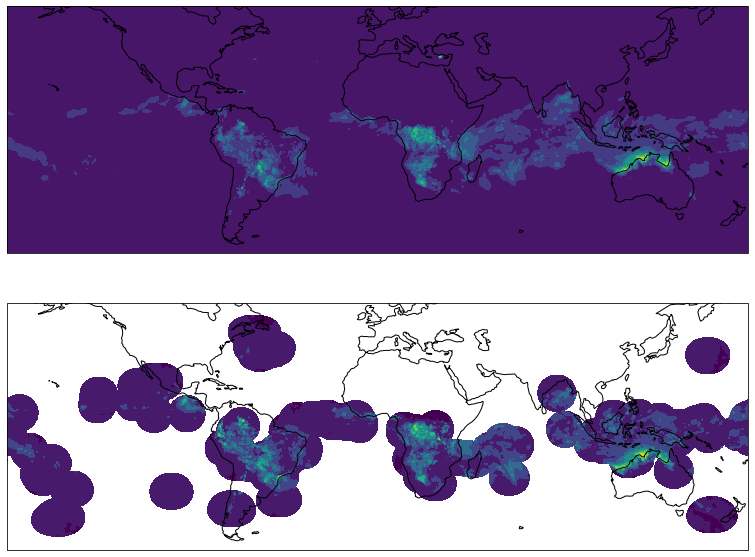

In [8]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
fig.set_size_inches((20, 10))

vmax = max(np.max(ds.cape.values[0]), np.nanmax(ds.mcs_local_cape.values[0, -1]))

ax1.contourf(ds.longitude, ds.latitude, ds.cape[0], vmin=0, vmax=vmax)
ax2.contourf(ds.longitude, ds.latitude, ds.mcs_local_cape[0, -1], vmin=0, vmax=vmax)
ax1.coastlines()
ax2.coastlines()

In [9]:
paths = [t.outputs['mcs_local_env'] for t in mle.CombineMonthlyMcsLocalEnv.tasks.filter(mode='init')]
print(len(paths))

exist_paths = [p for p in paths if p.exists()]
print(len(exist_paths))

ds_init = xr.open_mfdataset(exist_paths)

12
12


In [10]:
paths = [t.outputs['mcs_local_env'] for t in mle.CombineMonthlyMcsLocalEnv.tasks.filter(mode='lifecycle')]
print(len(paths))

exist_paths = [p for p in paths if p.exists()]
print(len(exist_paths))

ds_lifecycle = xr.open_mfdataset(exist_paths)

12
12


In [12]:
ds_init.attrs

{'ntimes_2020_01': 31}

(-60.0, 60.0)

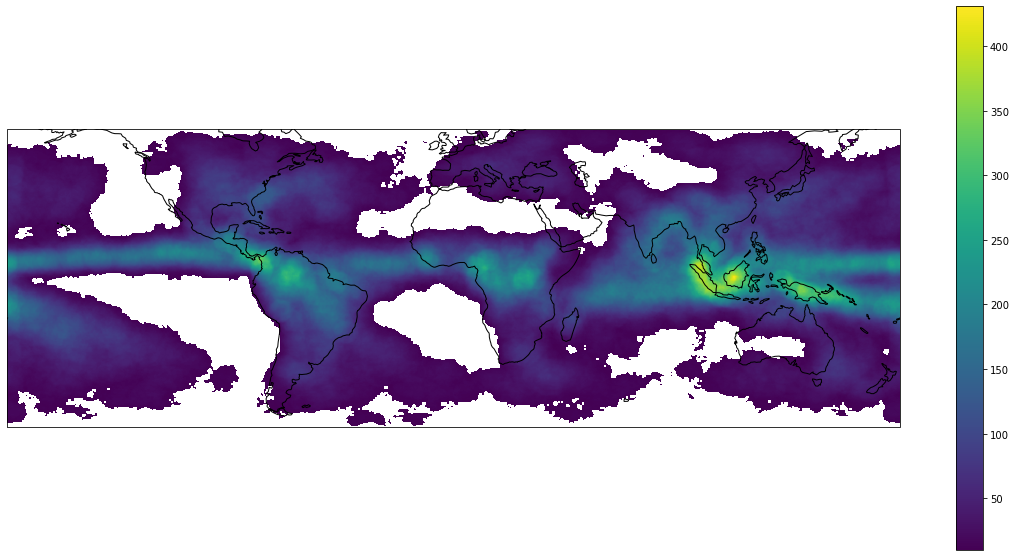

In [13]:
fig, ax1 = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches((20, 10))
mask_sum = ds_init.dist_mask_sum.sel(radius=500).sum(dim='time')
extent = (0, 360, -60, 60)
mask_sum_masked = np.ma.masked_array(mask_sum.values, mask=mask_sum < 10)
im1 = ax1.imshow(mask_sum_masked, extent=extent)
ax1.coastlines()
plt.colorbar(im1, ax=ax1)
ax1.set_ylim((-60, 60))

In [14]:
mask_sum

<xarray.DataArray 'dist_mask_sum' (latitude: 481, longitude: 1440)>
dask.array<sum-aggregate, shape=(481, 1440), dtype=float64, chunksize=(481, 1440), chunktype=numpy.ndarray>
Coordinates:
    radius     int64 500
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [42]:
def plot_var(ds, var, title, mode='time_mean'):
    # ds.load()
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1,
        subplot_kw=dict(projection=ccrs.PlateCarree()),
    )
    fig.set_size_inches((20, 15))
    ax1.set_title(title)
    
    mask_sum = ds_init.dist_mask_sum.sel(radius=ds.radius).sum(dim='time')
    # mask_sum_masked = np.ma.masked_array(mask_sum.values, mask=mask_sum < 10)
    
    da_var = ds[f'mcs_local_{var}']
    da_mean = ds[var]
    
    vmax = max(np.max(ds[var].values), np.nanmax(ds[f'mcs_local_{var}'].values))
    if mode == 'time_mean':
        diff = (da_var.mean(dim='time') - da_mean.mean(dim='time'))
    elif mode == 'monthly':
        diff = (da_var - da_mean).mean(dim='time')
        
    absmax_diff = np.abs(diff).max()
    if var == 'cape':
        levels1 = np.linspace(0, 1000, 11)
        levels2 = np.linspace(-500, 500, 11)
    elif var == 'tcwv':
        levels1 = np.linspace(0, 60, 11)
        levels2 = np.linspace(-30, 30, 11)
    elif var.startswith('shear'):
        levels1 = np.linspace(0, 20, 11)
        levels2 = np.linspace(-10, 10, 11)
    else:
        levels1 = np.linspace(-0.0015, 0.0015, 11)
        levels2 = np.linspace(-0.0005, 0.0005, 11)
    
    # im1 = ax1.contourf(ds.longitude, ds.latitude, ds[var], levels=levels1, extend='both')
    # im2 = ax2.contourf(ds.longitude, ds.latitude, ds[f'mcs_local_{var}'], levels=levels1, extend='both')
    # im3 = ax3.contourf(ds.longitude, ds.latitude, diff, levels=levels2, cmap='bwr', extend='both')
    extent = (0, 360, -60, 60)
    # print(da_mean)
    im1 = ax1.imshow(np.ma.masked_array(da_mean.mean(dim='time').values, mask=mask_sum < 10), vmin=levels1[0], vmax=levels1[-1], extent=extent)
    im2 = ax2.imshow(np.ma.masked_array(da_var.mean(dim='time').values, mask=mask_sum < 10), vmin=levels1[0], vmax=levels1[-1], extent=extent)
    im3 = ax3.imshow(np.ma.masked_array(diff.values, mask=mask_sum < 10), vmin=levels2[0], vmax=levels2[-1], cmap='bwr', extent=extent)
    
    plt.colorbar(im1, ax=[ax1, ax2], extend='max')
    plt.colorbar(im3, ax=ax3, extend='both')
    for ax in [ax1, ax2, ax3]:
        ax.coastlines()
        ax.set_ylim((-60, 60))

def plot_var_diff(ds, var, title):
    fig, ax1 = plt.subplots(
    1, 1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
    fig.set_size_inches((20, 5))
    plt.title(title)
    
    diff = (ds[f'mcs_local_{var}'] - ds[var])
    absmax_diff = np.abs(diff).max()
    if var == 'cape':
        levels = np.linspace(-500, 500, 11)
    elif var == 'tcwv':
        levels = np.linspace(-30, 30, 11)
    else:
        levels = 20
    
    im1 = ax1.contourf(ds.longitude, ds.latitude, diff, levels=levels, cmap='bwr', extend='both')
    
    ax1.coastlines()
    plt.colorbar(im1, ax=ax1, extend='both')

time_mean


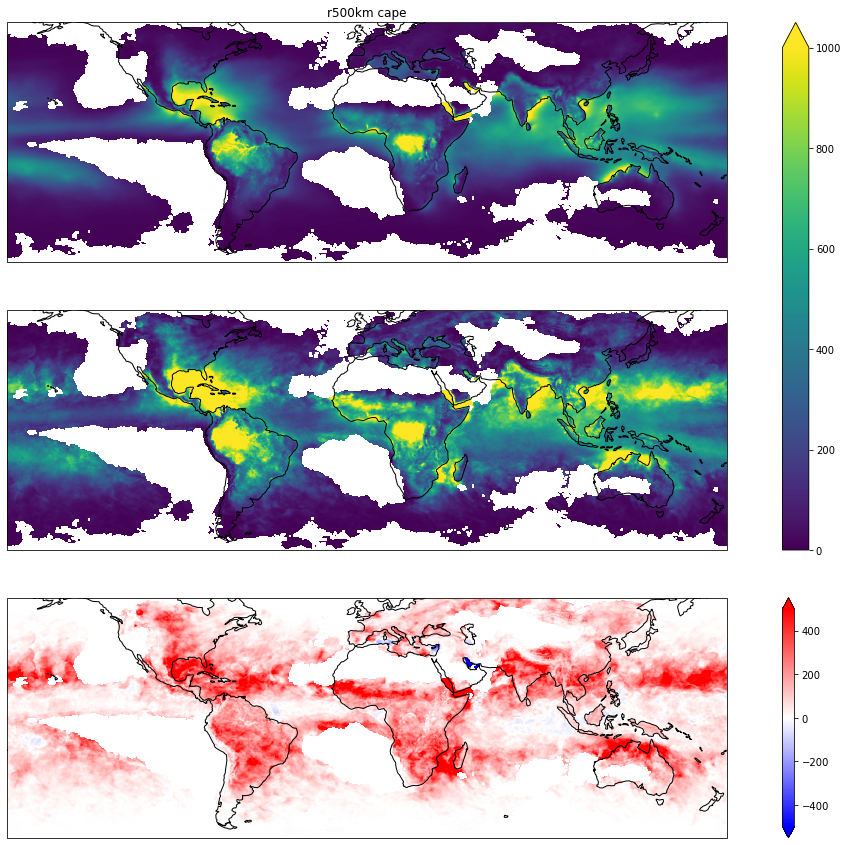

In [27]:
plot_var(ds_init.sel(radius=500), 'cape', 'r500km cape', 'time_mean')

monhtly


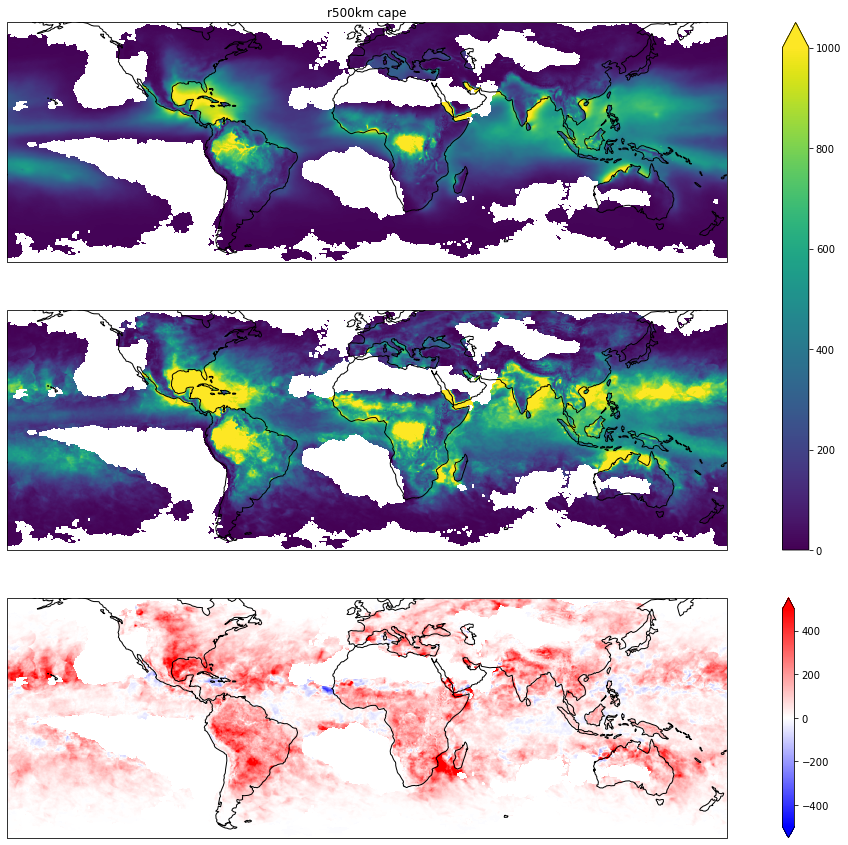

In [28]:
plot_var(ds_init.sel(radius=500), 'cape', 'r500km cape', 'monthly')

monhtly


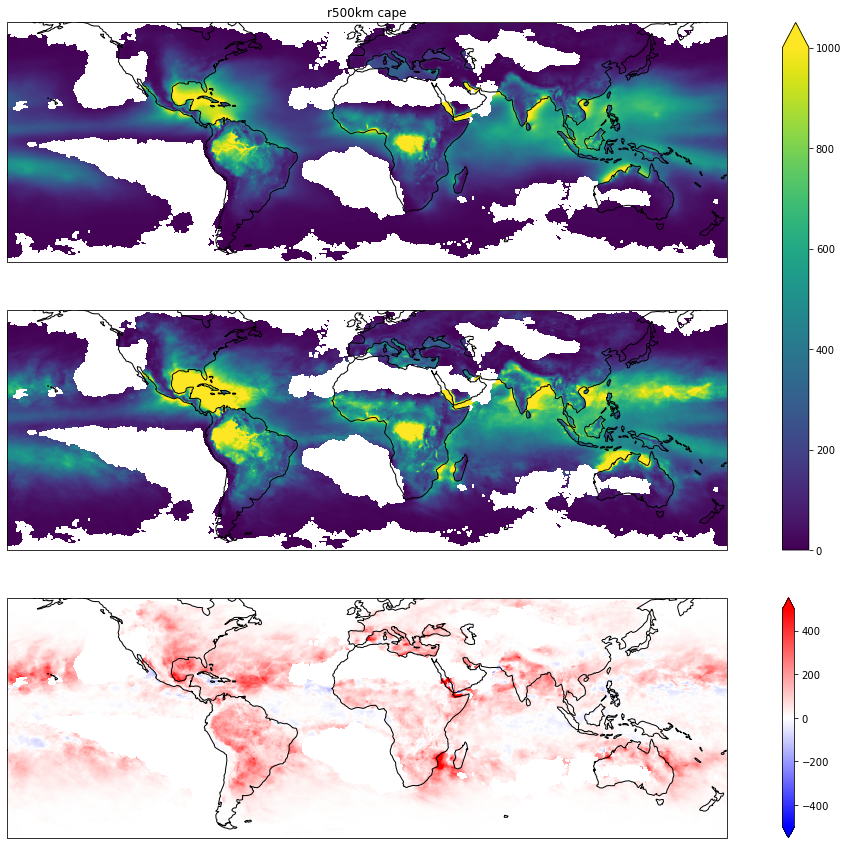

In [30]:
plot_var(ds_lifecycle.sel(radius=500), 'cape', 'r500km cape', 'monthly')

monhtly


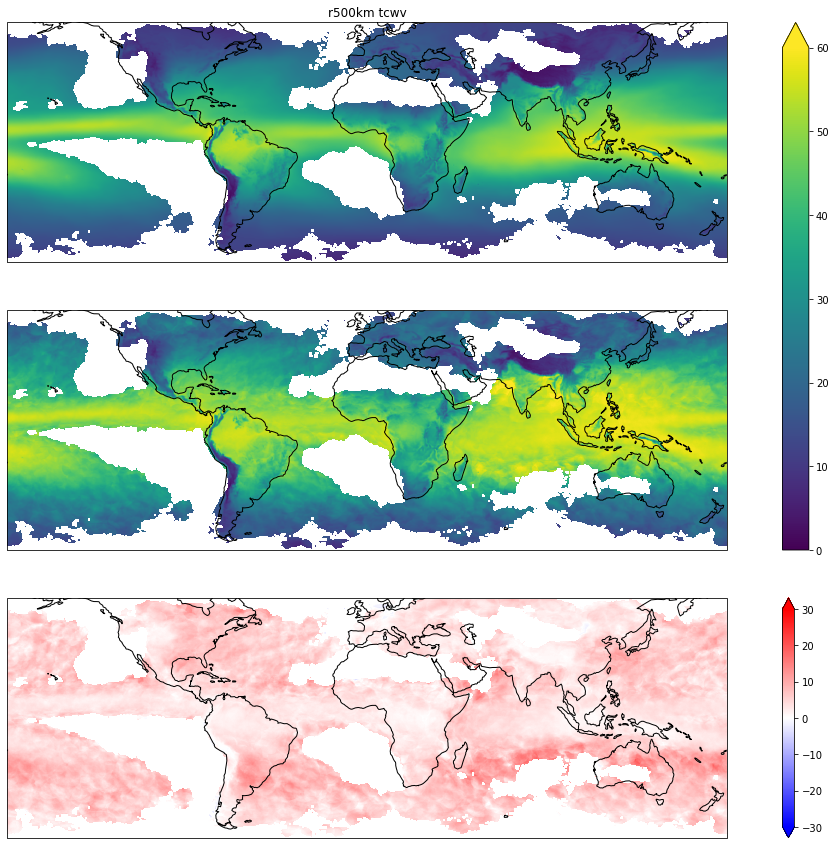

In [31]:
plot_var(ds_init.sel(radius=500), 'tcwv', 'r500km tcwv', 'monthly')

monhtly


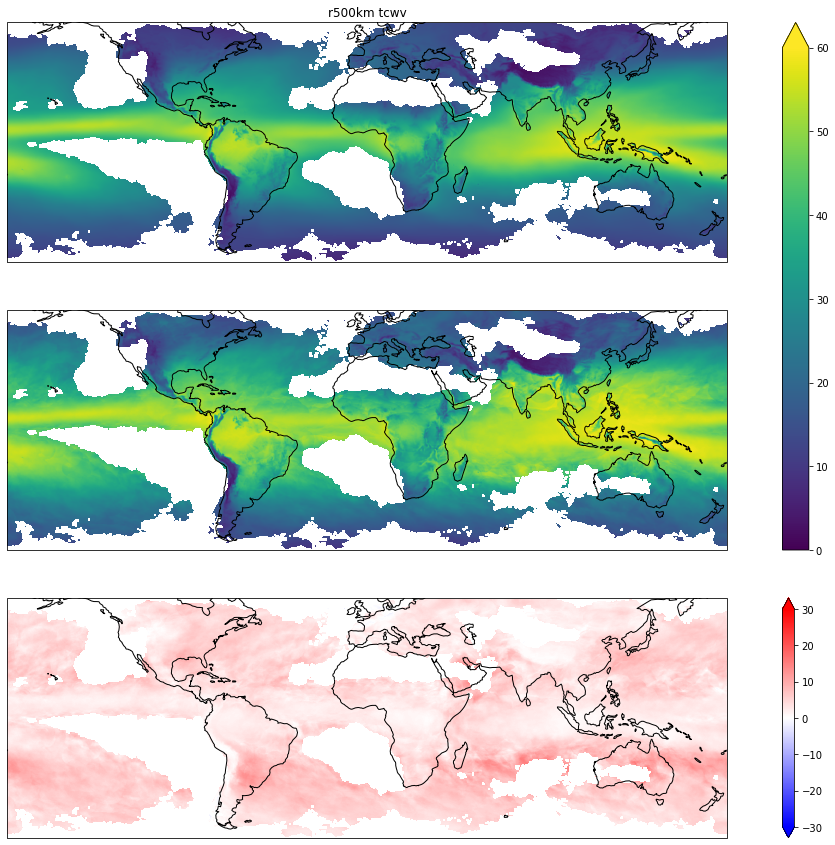

In [32]:
plot_var(ds_lifecycle.sel(radius=500), 'tcwv', 'r500km tcwv', 'monthly')

monhtly


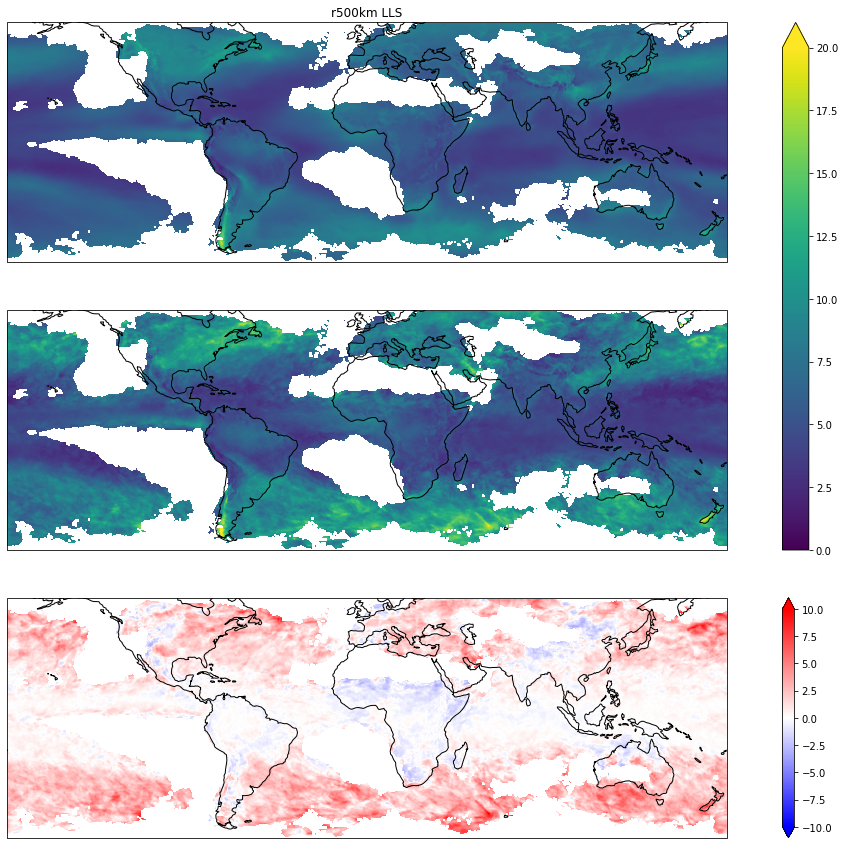

In [33]:
plot_var(ds_init.sel(radius=500), 'shear_0', 'r500km LLS', 'monthly')

monhtly


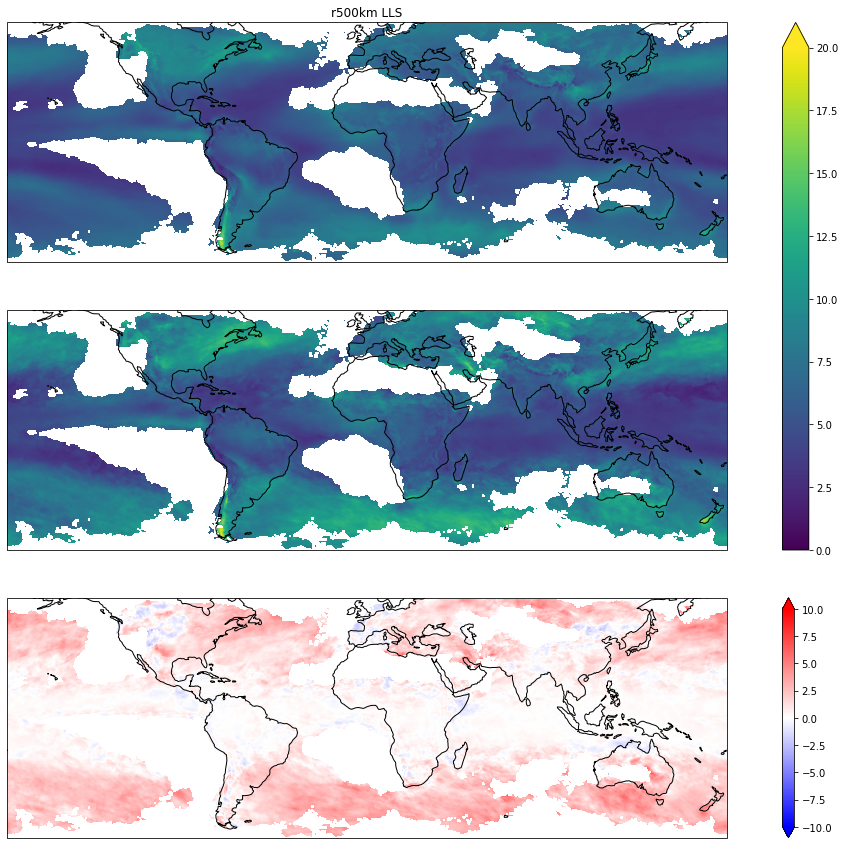

In [34]:
plot_var(ds_lifecycle.sel(radius=500), 'shear_0', 'r500km LLS', 'monthly')

monhtly


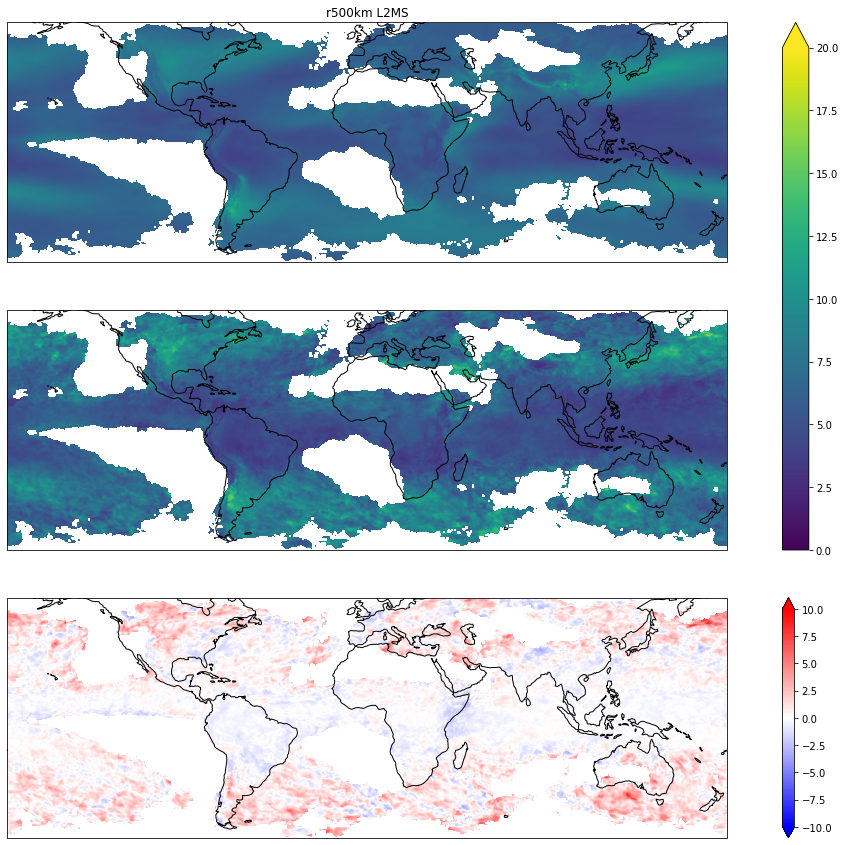

In [35]:
plot_var(ds_init.sel(radius=500), 'shear_1', 'r500km L2MS', 'monthly')

monhtly


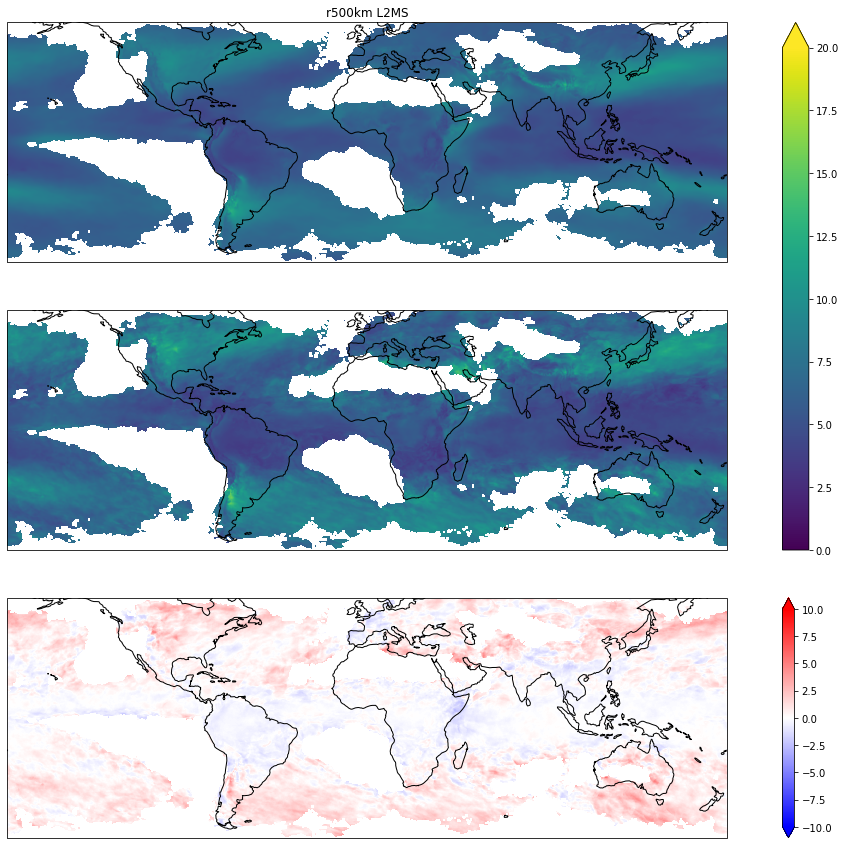

In [36]:
plot_var(ds_lifecycle.sel(radius=500), 'shear_1', 'r500km L2MS', 'monthly')

monhtly


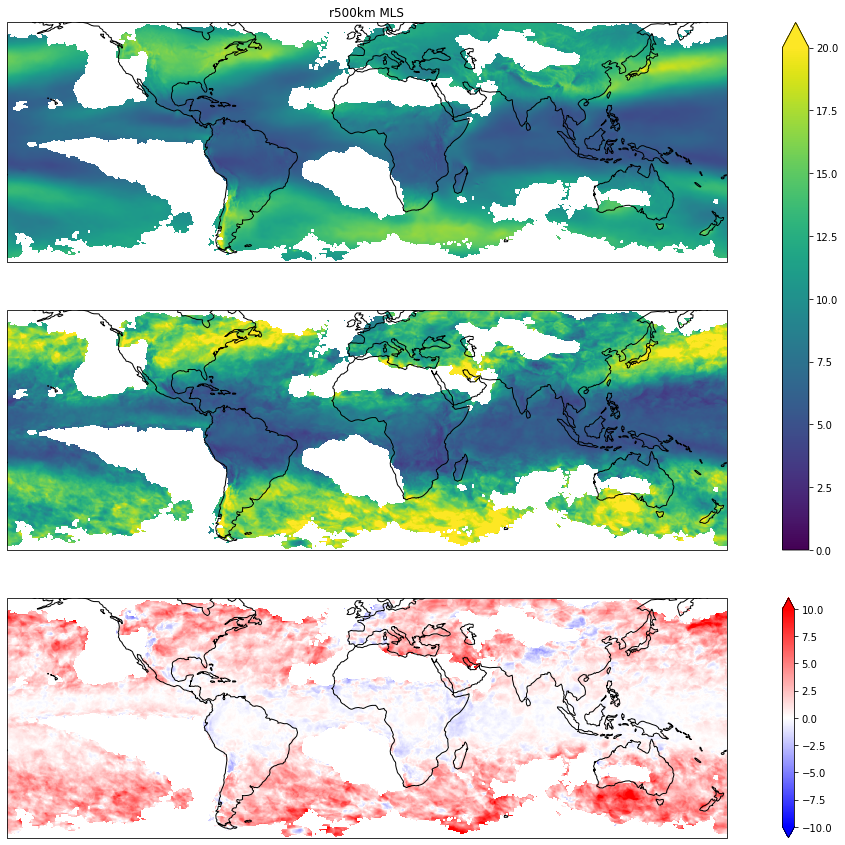

In [37]:
plot_var(ds_init.sel(radius=500), 'shear_2', 'r500km MLS', 'monthly')

monhtly


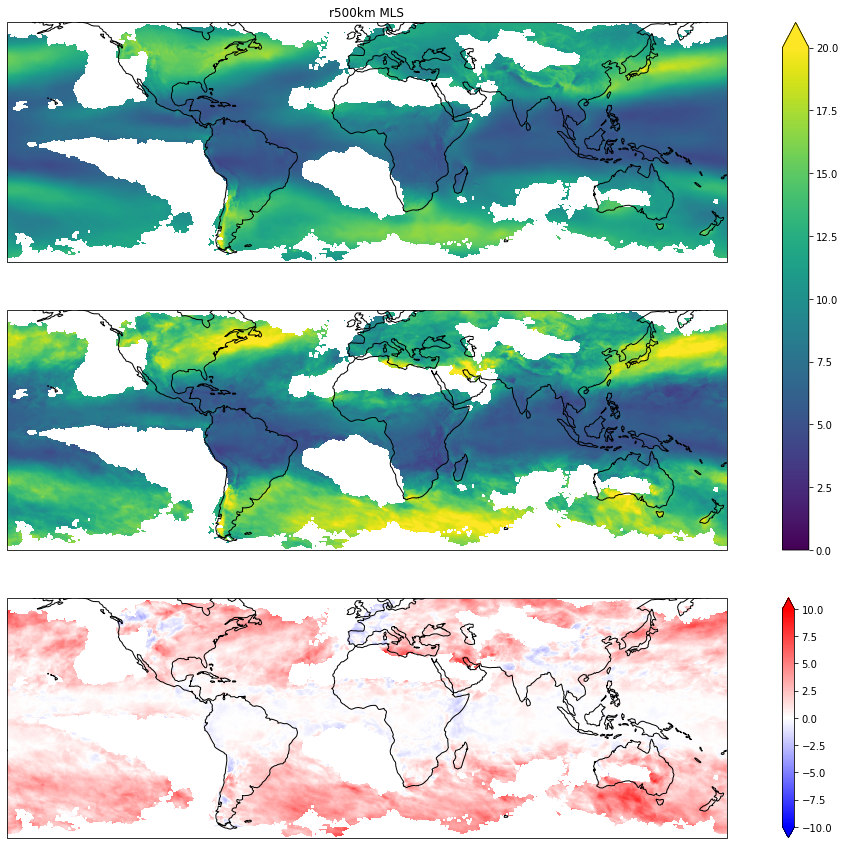

In [38]:
plot_var(ds_lifecycle.sel(radius=500), 'shear_2', 'r500km MLS', 'monthly')

monhtly


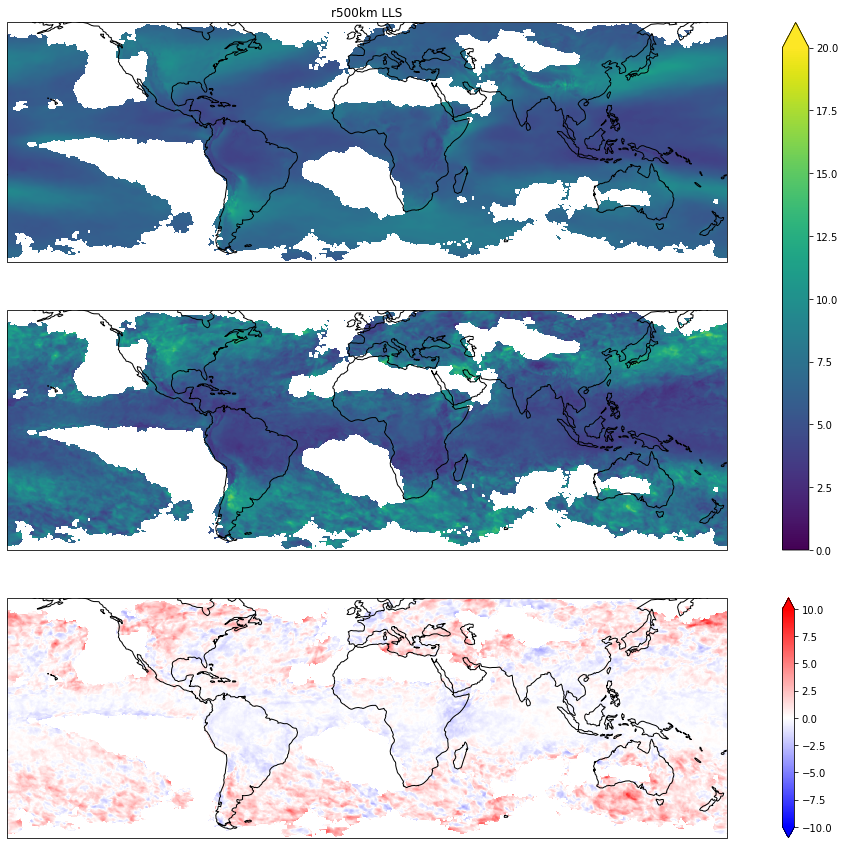

In [39]:
plot_var(ds_init.sel(radius=500), 'shear_1', 'r500km LLS', 'monthly')

monhtly


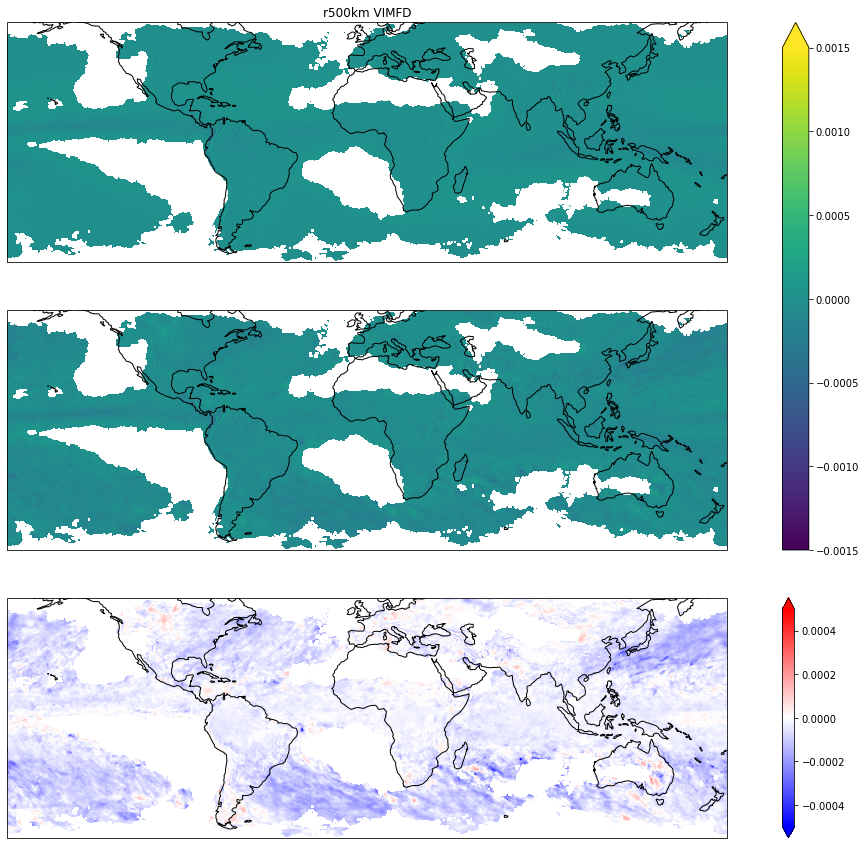

In [40]:
plot_var(ds_lifecycle.sel(radius=500), 'vertically_integrated_moisture_flux_div', 'r500km VIMFD', 'monthly')

monhtly


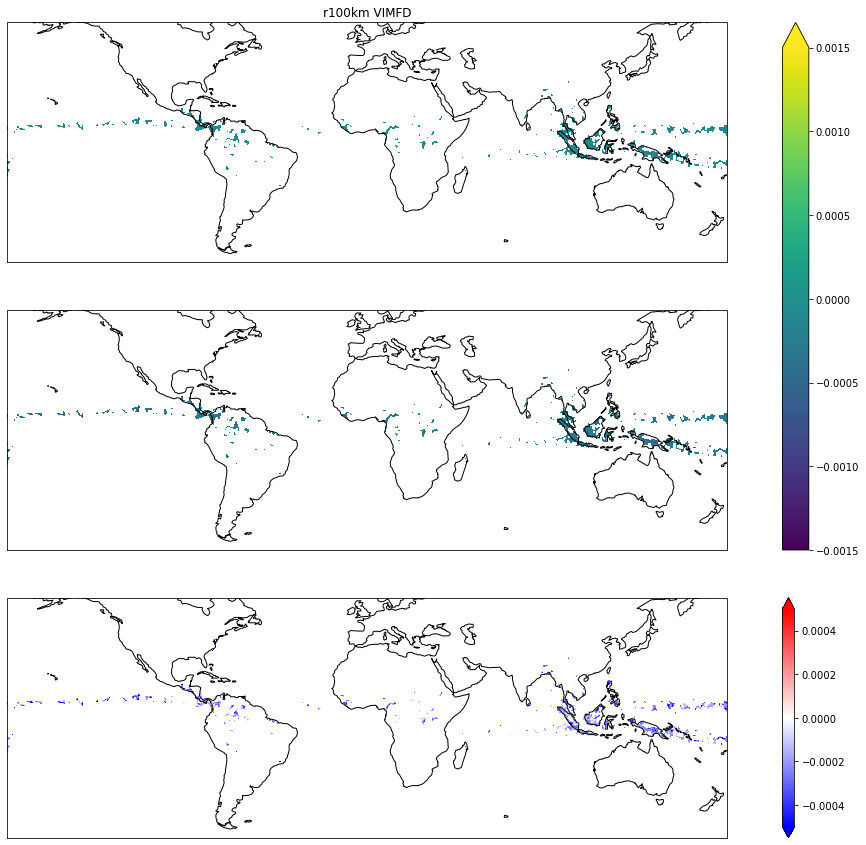

In [41]:
plot_var(ds_init.sel(radius=100), 'vertically_integrated_moisture_flux_div', 'r100km VIMFD', 'monthly')

In [ ]:
for r in [1, 100, 500, 1000]:
    print(r)
    plot_var_diff(ds.sel(radius=r).mean(dim='time'), 'cape', f'r{r}km cape')

In [ ]:
for r in [1, 100, 500, 1000]:
    print(r)
    plot_var_diff(ds.sel(radius=r).mean(dim='time'), 'tcwv', f'r{r}km tcwv')

In [ ]:
for i in range(1, 13):
    print(i)
    plot_var_diff(ds.isel(time=times.month == i).mean(dim='time'), 'cape', i)

In [ ]:
for i in range(1, 13):
    print(i)
    plot_var_diff(ds.isel(time=times.month == i).mean(dim='time'), 'tcwv', i)